In [14]:
!pip install gymnasium

In [2]:
import numpy as np
import gymnasium as gym
import os
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
from IPython.display import Image
from matplotlib import animation

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Initialize the environment

In [30]:
# Initialize the environment
env = gym.make('LunarLander-v3') #render_mode="human"

state_space = env.observation_space.shape[0]
print('State Space:', state_space)
action_space = env.action_space.n
print('Action Space:', action_space)

State Space: 8
Action Space: 4


### Policy

In [31]:
# Policy Network
class Policy(nn.Module):
    def __init__(self , s_size , a_size , h_size ):
        super (Policy , self ).__init__ ()
        self.fc1 = nn.Linear( s_size , h_size )
        self.fc2 = nn.Linear( h_size , h_size * 2)
        self.fc3 = nn.Linear( h_size * 2, a_size )
    def forward(self , x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim =1)
    def act(self, state ):
        state = torch.from_numpy(state).float().unsqueeze(0)  #.to(device)
        probs = self.forward(state) # .cpu()
        m = Categorical(probs)
        # Random action
        action = m.sample()
        return action.item() , m.log_prob(action)

### REINFORCE
Initialize the policy parameter $\theta$ at random. <br>
**for** each episode $\{s_1, a_1, r_2, s_2, a_2, \dots, s_T\} $ **do** <br>
&nbsp; &nbsp; &nbsp; &nbsp;     **for** $t=1, 2, … , T $ **do** <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Calculate the Return $G_t$ <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Update policy parameters $\theta \leftarrow \theta + \alpha \gamma^t G_t \nabla_\theta \log \pi_\theta(a_t \vert s_t)$ <br>
&nbsp; &nbsp; &nbsp; &nbsp; **end for** <br>
**end for**

Visually Explained: https://towardsdatascience.com/reinforcement-learning-explained-visually-part-6-policy-gradients-step-by-step-f9f448e73754

In [32]:
# Training Function
def reinforce(
        policy ,
        optimizer ,
        n_training_episodes ,
        max_steps ,
        gamma ,
        print_every
        ):
    # scores_deque = deque(maxlen =100)
    scores = []

    # Each Episode
    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]

        # t=1, 2, … , T (compute log(policy(a_t|s_t)))
        for t in range(max_steps):
            action , log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state , reward , done , _ , _ = env.step(action)
            rewards.append(reward)
            if done :
                break
        # scores_deque.append(sum( rewards ))
        scores.append(sum(rewards))

        returns = deque(maxlen = max_steps)
        n_steps = len(rewards)

        # List of discounted Returns (compute gamma^t*G_t)
        for t in range(n_steps)[:: -1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma*disc_return_t + rewards[t])

        # Total loss (disc_return = gamma^t*G_t; log_prob = log(policy(a_t|s_t)))
        policy_loss = []
        for log_prob , disc_return in zip( saved_log_probs , returns ):
            policy_loss.append(-log_prob * disc_return )
        policy_loss = torch.cat( policy_loss ).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        print(" Episode {}, Reward : {}".format( i_episode ,sum(rewards)))

    return scores


In [33]:
# Hyperparameter
h_size = 128
lr = 0.001
n_training_episodes = 2000
max_steps = 1000
gamma = 0.99

In [34]:
policy = Policy (
        s_size = state_space ,
        a_size = action_space ,
        h_size = h_size ,
        ) #.to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)

In [35]:
scores = reinforce (
        policy ,
        optimizer ,
        n_training_episodes ,
        max_steps ,
        gamma ,
        print_every = 100)

 Episode 1, Reward : -458.59467581186686
 Episode 2, Reward : -92.57889730749133
 Episode 3, Reward : -175.02095175551915
 Episode 4, Reward : -101.2919242885084
 Episode 5, Reward : -168.64590080392105
 Episode 6, Reward : -88.63658275695133
 Episode 7, Reward : -380.3992958923277
 Episode 8, Reward : -132.9217554169099
 Episode 9, Reward : -120.91447128738118
 Episode 10, Reward : -122.72412779467359
 Episode 11, Reward : -71.40093285495391
 Episode 12, Reward : -266.3132692411567
 Episode 13, Reward : -63.05630067778708
 Episode 14, Reward : -300.50179824929177
 Episode 15, Reward : -526.688545563622
 Episode 16, Reward : -529.9644140756739
 Episode 17, Reward : -77.91352898686458
 Episode 18, Reward : -109.17612422729582
 Episode 19, Reward : -150.8344104714887
 Episode 20, Reward : -88.98788182994643
 Episode 21, Reward : -169.53460543066714
 Episode 22, Reward : -56.6804593220528
 Episode 23, Reward : -366.9349730969903
 Episode 24, Reward : -72.35359969147481
 Episode 25, Reward

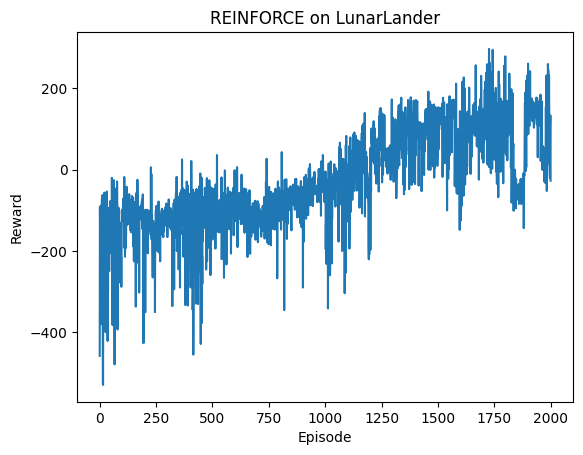

In [37]:
# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE on LunarLander')
plt.show()